* How often do users polarize? (polarization probability heatmap)
* How is polarization related to absolute/relative measures of time? (confounds)

In [1]:
partisan_dimen = "partisan"
political_activity_category = "all"

In [ ]:
import sys
import os
sys.path.append("..")
from commembed.jupyter import *
import commembed.linalg as linalg
import commembed.dimens as dimens
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from tqdm.notebook import tqdm
tqdm.pandas()
%config InlineBackend.figure_format = 'retina'
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
from pyspark.sql.functions import *

import commembed.data as data
import commembed.analysis as analysis


spark = data.spark_context()

%load_ext autoreload
%autoreload 2

In [ ]:
user_month_activity = data.load("user_partisan_scores_%s_%s" % (partisan_dimen, political_activity_category))
user_month_activity.createOrReplaceTempView("user_month_activity")

In [4]:
user_month_activity

DataFrame[author: string, calendar_month: string, month_since_join_index: bigint, active_month_index: int, num_comments: bigint, avg_z_score: double, avg_abs_z_score: double]

### Polarization probability

In [20]:
unaggregated_diffs = spark.sql("""
    select a1.calendar_month as m1, a2.calendar_month as m2,
        least(a1.num_comments, a2.num_comments) as min_comments,
        a1.avg_abs_z_score as m1_score,
        a2.avg_abs_z_score as m2_score,
        -- abs(a2.avg_z_score)-abs(a1.avg_z_score) as score_diff
        a2.avg_abs_z_score-a1.avg_abs_z_score as score_diff
        
    from user_month_activity as a1
    
    inner join user_month_activity as a2
    on a1.author = a2.author and a1.calendar_month != a2.calendar_month
""")
unaggregated_diffs.cache()

DataFrame[m1: string, m2: string, min_comments: bigint, m1_score: double, m2_score: double, score_diff: double]

In [21]:
# We want to generate two different types of CCDFs:
# one where num_comments is fixed and score_diff varies,
# and one where num_comments varies but score_diff is fixed
def generate_polprob_data(min_comments=None, score_diff=None):
    
    query = unaggregated_diffs
    key_columns = ["m1", "m2"]
    
    # min_comments
    if isinstance(min_comments, np.ndarray):
        mc_df = pd.DataFrame(min_comments, columns=["mc_thresh"])
        mc_df = spark.createDataFrame(mc_df)
        
        query = query.join(mc_df, mc_df["mc_thresh"] <= query["min_comments"], "inner")
        key_columns.append("mc_thresh")
    else:
        query = query.filter(query["min_comments"] >= min_comments)    
    
    
    # score_diff
    if isinstance(score_diff, np.ndarray):
        sd_df = pd.DataFrame(score_diff, columns=["sd_thresh"])
        sd_df = spark.createDataFrame(sd_df)
        
        query = query.crossJoin(sd_df)
        query = query.withColumn("sd_over", query["score_diff"] >= query["sd_thresh"])
        key_columns.append("sd_thresh")
    else:
        query = query.withColumn("sd_over", query["score_diff"] >= score_diff)
    
    query = query.groupBy(key_columns).agg(
        avg(query["sd_over"].cast("double")).alias("proportion_over")
    )
        
    return query
    
    
score_diff_bins = np.linspace(0, 2, 11)
sd_ccdf_data = generate_polprob_data(min_comments=10, score_diff=score_diff_bins).toPandas()

<AxesSubplot:xlabel='sd_thresh'>

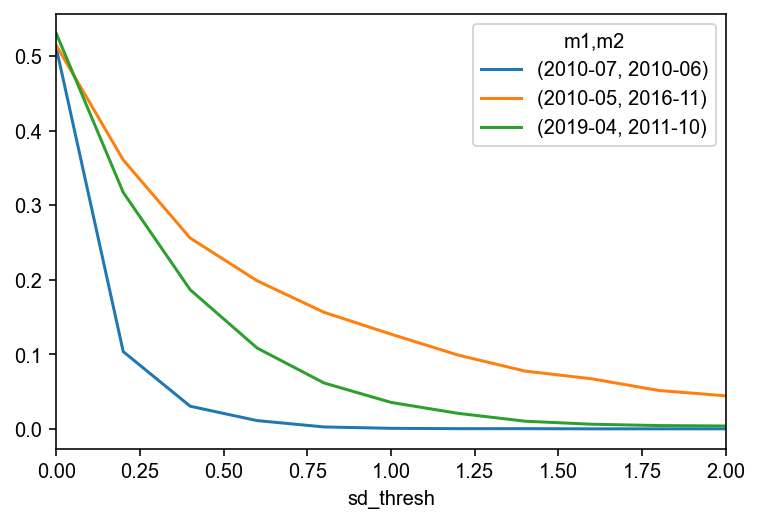

In [22]:
# score-diff CCDF
prototypical_sd_thresh = 1

# calculate months of interest
to_plot = sd_ccdf_data
to_plot = to_plot[to_plot["m1"] > "2010"]
to_plot = to_plot[to_plot["m2"] > "2010"]
to_plot = to_plot[to_plot["sd_thresh"] == prototypical_sd_thresh].set_index(["m1","m2"])
to_plot = to_plot.sort_values("proportion_over")
months_of_interest = [to_plot.index[0], to_plot.index[-1], to_plot.index[len(to_plot.index) // 2]]

to_plot = pd.pivot_table(sd_ccdf_data, values="proportion_over", index=["m1","m2"], columns="sd_thresh")
to_plot = to_plot.loc[months_of_interest]
to_plot.to_csv(os.path.join(data.DATA_PATH, "user_dynamic_polprob_ccdf_sd_thresh_%s_%s.csv" % (partisan_dimen, political_activity_category)), index=True)
to_plot.T.plot.line()

In [23]:
min_comments_bins = np.arange(1, 50)
mc_ccdf_data = generate_polprob_data(min_comments=min_comments_bins, score_diff=1).toPandas()

<AxesSubplot:xlabel='mc_thresh'>

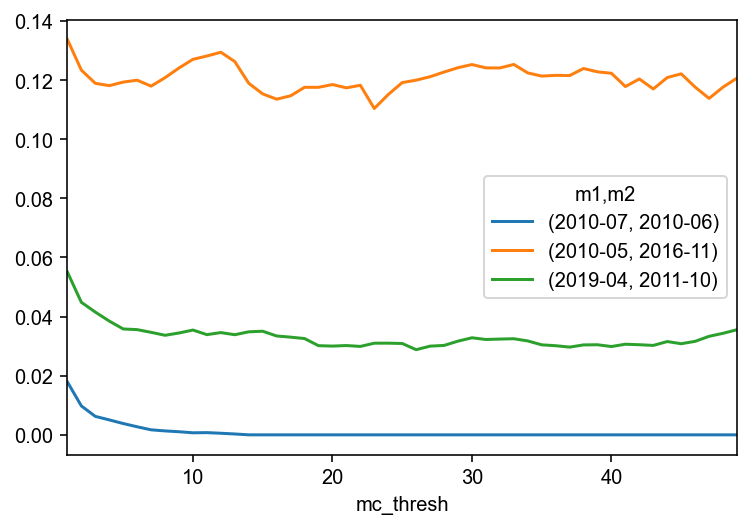

In [24]:
to_plot = pd.pivot_table(mc_ccdf_data, values="proportion_over", index=["m1","m2"], columns="mc_thresh")
to_plot = to_plot.loc[months_of_interest]
to_plot.to_csv(os.path.join(data.DATA_PATH, "user_dynamic_polprob_ccdf_mc_thresh_%s_%s.csv" % (partisan_dimen, political_activity_category)), index=True)
to_plot.T.plot.line()

<AxesSubplot:xlabel='m2', ylabel='m1'>

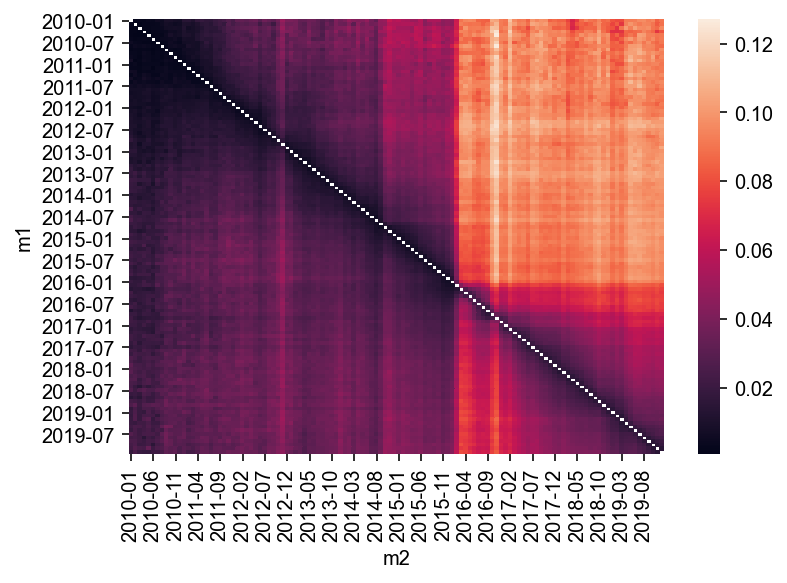

In [25]:
# Final choices for parameters (sd = 1, mc = 10)
import seaborn as sns

to_plot = sd_ccdf_data
to_plot = to_plot[to_plot["sd_thresh"] == 1]
to_plot = to_plot[to_plot["m1"] > "2010"]
to_plot = to_plot[to_plot["m2"] > "2010"]
to_plot.to_csv(os.path.join(data.DATA_PATH, "user_dynamic_polprob_%s_%s.csv" % (partisan_dimen, political_activity_category)), index=True)
to_plot = to_plot.pivot(index="m1", columns="m2", values="proportion_over")

sns.heatmap(to_plot)

In [26]:
# correlation heatmap and average difference heatmap
query = unaggregated_diffs
query = query.filter(query["min_comments"] >= 10)

query = query.groupBy(["m1", "m2"]).agg(
    corr("m1_score", "m2_score").alias("pearson_r"),
    avg(query["m2_score"] - query["m1_score"]).alias("avg_raw_score_diff"),
    avg(query["score_diff"]).alias("avg_score_diff")
)

heatmap_data = query.toPandas()

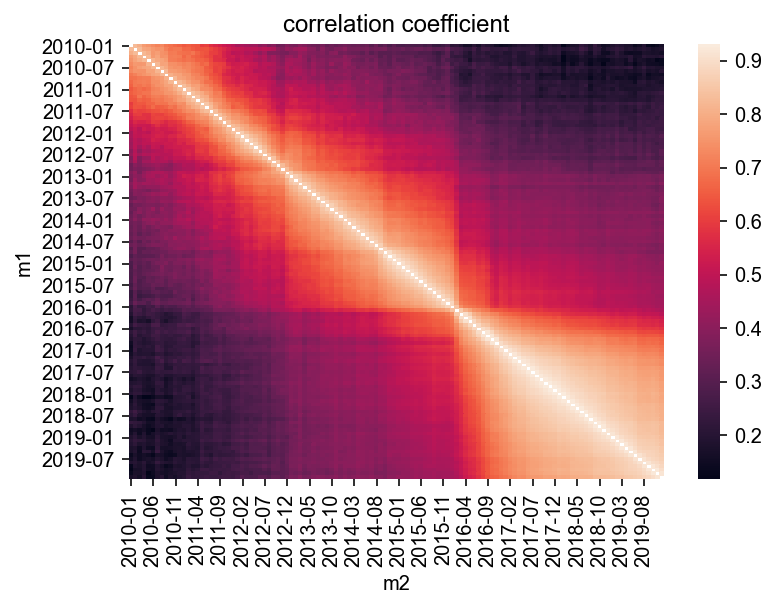

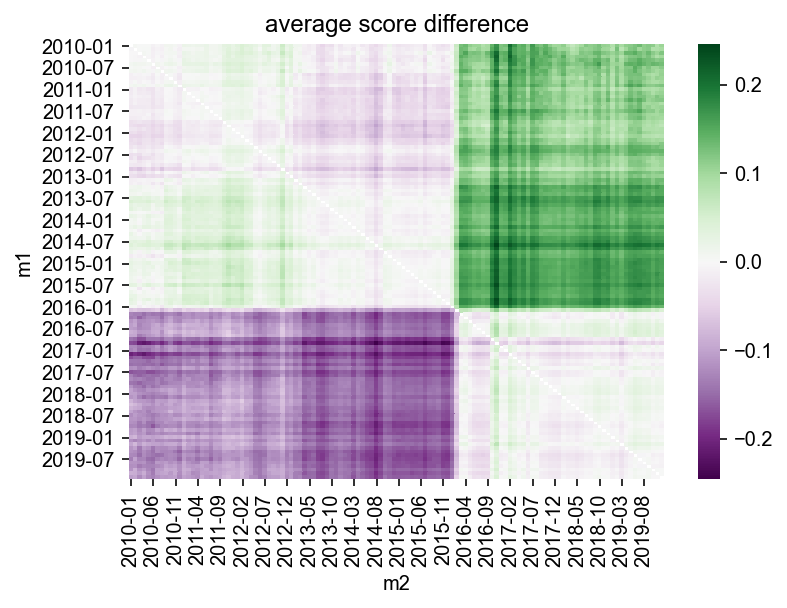

In [27]:
to_plot = heatmap_data
to_plot = to_plot[to_plot["m1"] > "2010"]
to_plot = to_plot[to_plot["m2"] > "2010"]
to_plot.to_csv(os.path.join(data.DATA_PATH, "user_dynamic_correlation_%s_%s.csv" % (partisan_dimen, political_activity_category)), index=True)
sns.heatmap(to_plot.pivot(index="m1", columns="m2", values="pearson_r"))
plt.title("correlation coefficient")
plt.show()

sns.heatmap(to_plot.pivot(index="m1", columns="m2", values="avg_score_diff"), cmap="PRGn")
plt.title("average score difference")
plt.show()

### Confounds

In [13]:
def query_confound(confound):
    return spark.sql(f"""
        select {confound} as confound, 
            sum(avg_abs_z_score*num_comments)/sum(num_comments) as avg_abs_z_score,
            sum(num_comments) as num_comments
        
        from user_month_activity
        
        group by 1
    """)
    
    
confound_calendar_month = query_confound("calendar_month").toPandas()
confound_month_since_join = query_confound("month_since_join_index").toPandas()
confound_active_month = query_confound("active_month_index").toPandas()

/u/walleris/miniconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1182: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


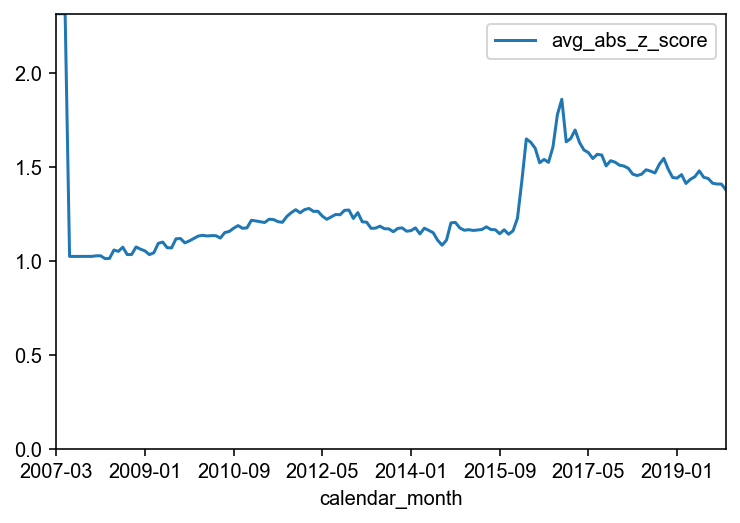

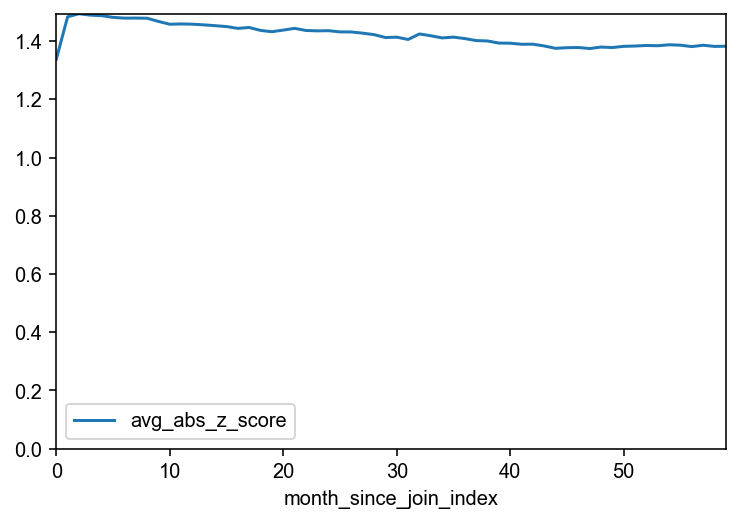

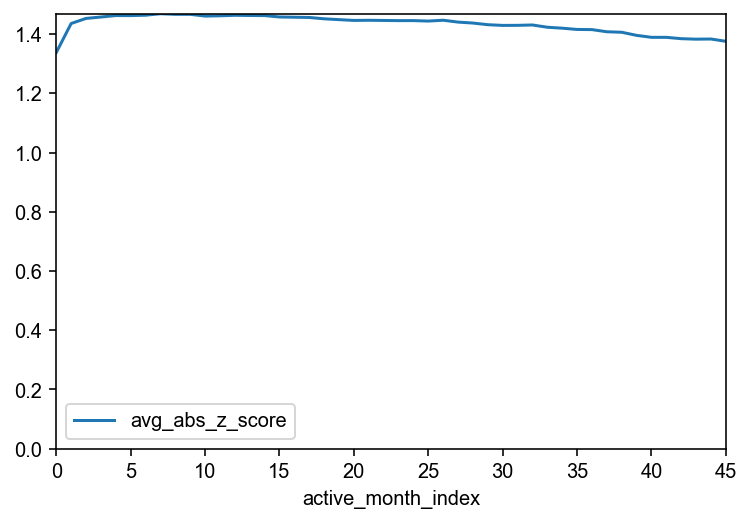

In [19]:

def plot_confound(df, name):
    
    df = df.sort_values("confound").set_index("confound")
    
    max_comments = np.amax(df["num_comments"])
    cutoff = np.where(df["num_comments"] >= (max_comments * 0.1))[0][-1]
    df = df.iloc[0:cutoff+1]
    
    df.plot.line(y="avg_abs_z_score")
    plt.gca().set_ylim(0, np.amax(df["avg_abs_z_score"]))
    plt.xlabel(name)
    df.to_csv(os.path.join(data.DATA_PATH, "user_confound_%s_%s_%s.csv" % (name, partisan_dimen, political_activity_category)), index=True)


plot_confound(confound_calendar_month, "calendar_month")
plot_confound(confound_month_since_join, "month_since_join_index")
plot_confound(confound_active_month, "active_month_index")